In [ ]:
!pip install --upgrade diffusers transformers scipy
!pip install accelerate
!pip install pillow
!pip install sentence_transformers

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/tokens .
    
Token: 
Add token as git credential? (Y/n) n
Token is valid.
Your token has been saved to /root/.huggingface/token
Login successful


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline
import tensorflow as tf
from PIL import Image
import numpy as np

model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained(model_id, use_auth_token=True)
pipe = pipe.to(device)

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/313 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/592 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/522 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


In [ ]:
VGG16 = tf.keras.applications.VGG16(include_top=True, weights='imagenet')
x = VGG16.layers[-2].output
VGG16_MODEL = tf.keras.Model(inputs = VGG16.input, outputs = x)
VGG16_MODEL.trainable = False
VGG16_MODEL.summary()

553467096/553467096 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
# generate image from stable-diffusion
def get_image_stable_diffusion(prompt):
  with autocast("cuda"):
    image = pipe(prompt, guidance_scale=7.5) 
    
  # image.save("image.png")
  # print(image)
  img = image.images[0]
  return img, image

In [ ]:
from tensorflow.keras.utils import img_to_array
# generate two images to compare
def get_images(prompt1, prompt2):
  # size = 224, 224
  img1, image1 = get_image_stable_diffusion(prompt1)
  img2, image2 = get_image_stable_diffusion(prompt2)
  return img1, img2, image1, image2

In [ ]:
from tqdm import tqdm
import datetime
def save_images(filename, dir):
  images_list = []
  with open(filename) as f:
    lines = [line.rstrip('\n').split(':') for line in f]
  print(lines)
  for line in tqdm(lines):
    if len(line) == 1:
      line1 = line[0]
      line2 = line[0]  
    else:
      line1 = line[0]
      line2 = line[1]
    # img1, img2, image1, image2 = get_images(line1, line2)
    img1, image1 = get_image_stable_diffusion(line1)
    date = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    name1 = dir + date + "-" + line1 + ".png"
    if image1.nsfw_content_detected[0] == True:
      continue
    img2, image2 = get_image_stable_diffusion(line2)
    date = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    name2 = dir + date + "-" + line2 + ".png"
    if image2.nsfw_content_detected[0] == True:
      continue
    images_list += [img1, img2]
    img1.save(name1)
    img2.save(name2)
  return images_list

In [ ]:
same_images_list = save_images("/content/drive/MyDrive/523/new_prompts/text_ptompts_same.txt", "/content/drive/MyDrive/523/stable_diffusion_images/same/")

In [ ]:
len(same_images_list)

In [ ]:
mod_images_list = save_images("/content/drive/MyDrive/523/new_prompts/text_ptompts_modified.txt", "/content/drive/MyDrive/523/stable_diffusion_images/modified/")

In [ ]:
len(mod_images_list)

206

## Images generated with same prompts

In [ ]:
same_img1, same_img2, _, _ = get_images("A painting of a baby riding a blue bike", "A painting of a baby riding a blue bike")

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
size = 255, 255
same_img1.thumbnail(size)
same_img2.thumbnail(size)

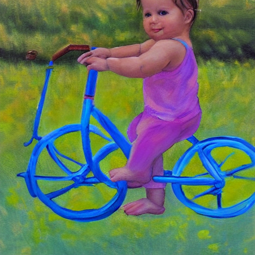

In [ ]:
same_img1

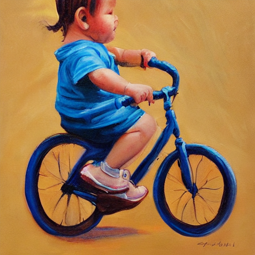

In [ ]:
same_img2

## Images generated with small modification to the prompts

In [ ]:
diff_img1, diff_img2, _, _ = get_images("A painting of a baby riding a red bike", "Painting of a baby riding a blue bike")

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
size = 255, 255
diff_img1.thumbnail(size)
diff_img2.thumbnail(size)

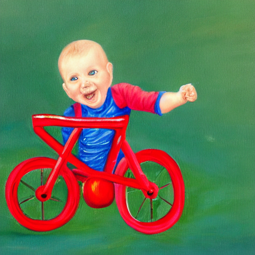

In [ ]:
diff_img1

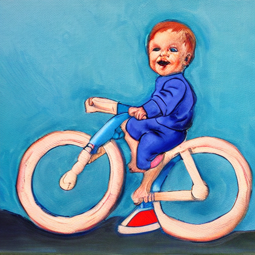

In [ ]:
diff_img2

# Images generated with different prompts

In [ ]:
comp_diff_img1, comp_diff_img2, _, _ = get_images("A painting of a baby riding a bike", "A pink horse on the sea")

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

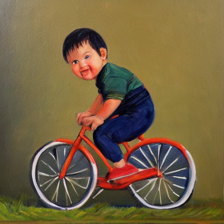

In [ ]:
comp_diff_img1

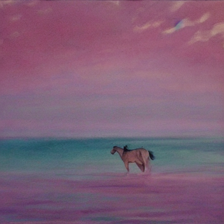

In [ ]:
comp_diff_img2

# Load the images

In [ ]:
from PIL import Image
import glob
same_images_list = []
for filename in glob.glob("/content/drive/MyDrive/523/stable_diffusion_images/same/*.png"):
    im=Image.open(filename)
    same_images_list.append(im)

mod_images_list = []
for filename in glob.glob("/content/drive/MyDrive/523/stable_diffusion_images/modified/*.png"):
    im=Image.open(filename)
    mod_images_list.append(im)
  
import copy, random
diff_images_list = copy.deepcopy(mod_images_list)
random.shuffle(diff_images_list)

In [ ]:
same_images_list = same_images_list[:200]
mod_images_list = mod_images_list[:200]
diff_images_list = diff_images_list[:200]

In [ ]:
len(diff_images_list)

200

# Similarity metrics

## L2 Norm

In [ ]:
# Helper functions
def image_to_feature_vector(img):
    return np.array(tf.squeeze(VGG16_MODEL(tf.expand_dims(img, 0))))

from numpy.linalg import norm
def similarity(v1, v2):
    v1 /= norm(v1)
    v2 /= norm(v2)
    return 1. - norm(v2 - v1)

In [ ]:
def get_similarity(img1, img2):
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])

  image1 = tf.image.resize_with_pad(img1, 224, 224)
  # Normalize
  image1 = tf.math.divide(image1, 255.)
  image1 = tf.math.subtract(image1, mean)
  image1 = tf.math.divide(image1, std)
  image1 = image_to_feature_vector(image1)

  image2 = tf.image.resize_with_pad(img2, 224, 224)
  # Normalize
  image2 = tf.math.divide(image2, 255.)
  image2 = tf.math.subtract(image2, mean)
  image2 = tf.math.divide(image2, std)
  image2 = image_to_feature_vector(image2)

  sim = similarity(image1, image2)
  return sim

## Cosine similarity

In [ ]:
from scipy.spatial.distance import cosine
def get_cosine_sim(img1, img2):
  return 1 - cosine(img1, img2)

## Inception score

In [ ]:
# from tf.keras.applications.inception_v3 import InceptionV3
# from tf.keras.applications.inception_v3 import preprocess_input
from math import floor
from numpy import ones
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
# load inception v3 model
inception_model = tf.keras.applications.inception_v3.InceptionV3()
def calculate_inception_score(images, eps=1E-16):
  images = np.array(images)
  processed = images.astype('float32')
  # pre-process raw images for inception v3 model
  processed = tf.keras.applications.inception_v3.preprocess_input(processed)
  # predict class probabilities for images
  yhat = inception_model.predict(processed, verbose=False)
  # enumerate splits of images/predictions
  p_yx = yhat
  # calculate p(y)
  p_y = expand_dims(p_yx.mean(axis=0), 0)
  # calculate KL divergence using log probabilities
  kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
  # sum over classes
  sum_kl_d = kl_d.sum(axis=1)
  # average over images
  avg_kl_d = mean(sum_kl_d)
  # undo the log
  is_score = exp(avg_kl_d)
  return is_score

96112376/96112376 [==============================] - 4s 0us/step


In [ ]:
def get_average_is(images):
  inception_scores = []
  for i in range(0, len(images), 2):
    img1 = copy.deepcopy(images[i])
    img2 = copy.deepcopy(images[i+1])
    size = 299, 299
    img1.thumbnail(size)
    img2.thumbnail(size)
    np_img1 = img_to_array(img1)
    np_img2 = img_to_array(img2)
    is_score = calculate_inception_score([np_img1, np_img2])
    inception_scores.append(is_score)
  return np.mean(np.array(inception_scores)), np.var(np.array(inception_scores))

In [ ]:
is_same_mean, is_same_var = get_average_is(same_images_list)

In [ ]:
print("Mean inception score for same prompt pairs:", is_same_mean)
print("Variance of the inception scores for same prompt pairs:", is_same_var)

Mean inception score for same prompt pairs: 1.4532787
Variance of the inception scores for same prompt pairs: 0.06552093


In [ ]:
is_mod_mean, is_mod_var = get_average_is(mod_images_list)

In [ ]:
print("Mean inception score for prompt pairs with small modifications:", is_mod_mean)
print("Variance of the inception scores for prompt pairs with small modifications:", is_mod_var)

Mean inception score for prompt pairs with small modifications: 1.4411635
Variance of the inception scores for prompt pairs with small modifications: 0.058156416


In [ ]:
is_diff_mean, is_diff_var= get_average_is(diff_images_list)

In [ ]:
print("Mean inception score for different prompt pairs:", is_diff_mean)
print("Variance of the inception scores for different prompt pairs:", is_diff_var)

Mean inception score for different prompt pairs: 1.7010095
Variance of the inception scores for different prompt pairs: 0.039467733


# VGG16 Feature vector

In [ ]:
import copy
from tqdm import tqdm
def vgg16_similarity(images):
  l2_sim_scores = []
  cosine_sim_scores = []
  fad_scores = []
  for i in tqdm(range(0, len(images), 2)):
    img1 = copy.deepcopy(images[i])
    img2 = copy.deepcopy(images[i+1])
    size = 224, 224
    img1.thumbnail(size)
    img2.thumbnail(size)
    np_img1 = img_to_array(img1)
    np_img2 = img_to_array(img2)
    # L2 Norm
    l2_sim = get_similarity(np_img1, np_img2)
    # Cosine similarity
    cosine_sim = get_cosine_sim(image_to_feature_vector(np_img1), image_to_feature_vector(np_img2))
    l2_sim_scores.append(l2_sim)
    cosine_sim_scores.append(cosine_sim)

  return np.mean(np.array(l2_sim_scores)), np.var(np.array(l2_sim_scores)), np.mean(np.array(cosine_sim_scores)), np.var(np.array(cosine_sim_scores))

In [ ]:
vgg_l2_same_mean, vgg_l2_same_var, vgg_cosine_same_mean, vgg_cosine_same_var = vgg16_similarity(same_images_list)

100%|██████████| 100/100 [00:07<00:00, 13.63it/s]


In [ ]:
print("Mean L2 Norm similarity score for same prompt pairs:", vgg_l2_same_mean)
print("Variance of the L2 Norm similarity scores for same prompt pairs:", vgg_l2_same_var)
print("Mean cosine similarity score for same prompt pairs:", vgg_cosine_same_mean)
print("Variance of the cosine similarity scores for same prompt pairs:", vgg_cosine_same_var)

Mean L2 Norm similarity score for same prompt pairs: 0.6695476385951042
Variance of the L2 Norm similarity scores for same prompt pairs: 0.004683875666977167
Mean cosine similarity score for same prompt pairs: 0.47647074893116953
Variance of the cosine similarity scores for same prompt pairs: 0.017826829613869066


In [ ]:
vgg_l2_mod_mean, vgg_l2_mod_var, vgg_cosine_mod_mean, vgg_cosine_mod_var = vgg16_similarity(mod_images_list)

100%|██████████| 100/100 [00:06<00:00, 14.95it/s]


In [ ]:
print("Mean L2 Norm similarity score for prompt pairs with small modifications:", vgg_l2_mod_mean)
print("Variance of the L2 Norm similarity scores for prompt pairs with small modifications:", vgg_l2_mod_var)
print("Mean cosine similarity score for prompt pairs with small modifications:", vgg_cosine_mod_mean)
print("Variance of the cosine similarity scores for prompt pairs with small modifications:", vgg_cosine_mod_var)

Mean L2 Norm similarity score for prompt pairs with small modifications: 0.6614352120459079
Variance of the L2 Norm similarity scores for prompt pairs with small modifications: 0.0038953602679391015
Mean cosine similarity score for prompt pairs with small modifications: 0.4759840627014637
Variance of the cosine similarity scores for prompt pairs with small modifications: 0.015055842686558643


In [ ]:
vgg_l2_diff_mean, vgg_l2_diff_var, vgg_cosine_diff_mean, vgg_cosine_diff_var = vgg16_similarity(diff_images_list)

100%|██████████| 100/100 [00:06<00:00, 15.65it/s]


In [ ]:
print("Mean L2 Norm similarity score for different prompt pairs:", vgg_l2_diff_mean)
print("Variance of the L2 Norm similarity scores for different prompt pairss:", vgg_l2_diff_var)
print("Mean cosine similarity score for different prompt pairs:", vgg_cosine_diff_mean)
print("Variance of the cosine similarity scores for different prompt pairs:", vgg_cosine_diff_var)

Mean L2 Norm similarity score for different prompt pairs: 0.5468646466732026
Variance of the L2 Norm similarity scores for different prompt pairss: 0.005901322577365384
Mean cosine similarity score for different prompt pairs: 0.24975158102810383
Variance of the cosine similarity scores for different prompt pairs: 0.006868269298740864


# Using CLIP Model's dense representations 

In [ ]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import glob
import os

# Load the OpenAI CLIP Model
print('Loading CLIP Model...')
model = SentenceTransformer('clip-ViT-B-32')

Loading CLIP Model...


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/605M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/604 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/961k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.88k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


In [ ]:
def get_clip_encoding(img1, img2):
  encoded_image = model.encode([img1, img2], batch_size=2, convert_to_tensor=True)
  return encoded_image

In [ ]:
import copy
def clip_similarity(images):
  l2_sim_scores = []
  cosine_sim_scores = []
  inception_scores = []
  fad_scores = []
  for i in tqdm(range(0, len(images), 2)):
    img1 = copy.deepcopy(images[i])
    img2 = copy.deepcopy(images[i+1])
    encoded_image = get_clip_encoding(img1, img2)
    l2_sim = similarity(encoded_image[0].cpu(), encoded_image[1].cpu())
    # Cosine similarity
    cosine_sim = get_cosine_sim(encoded_image[0].cpu(), encoded_image[1].cpu())
    l2_sim_scores.append(l2_sim)
    cosine_sim_scores.append(cosine_sim)

  return np.mean(np.array(l2_sim_scores)), np.var(np.array(l2_sim_scores)), np.mean(np.array(cosine_sim_scores)), np.var(np.array(cosine_sim_scores))

In [ ]:
clip_same_mean, clip_same_var, clip_cosine_same_mean, clip_cosine_same_var = clip_similarity(same_images_list)

100%|██████████| 100/100 [00:03<00:00, 28.99it/s]


In [ ]:
print("Mean L2 Norm similarity score for same prompt pairs:", clip_same_mean)
print("Variance of the L2 Norm similarity scores for same prompt pairs:", clip_same_var)
print("Mean cosine similarity score for same prompt pairs:", clip_cosine_same_mean)
print("Variance of the cosine similarity scores for same prompt pairs:", clip_cosine_same_var)

Mean L2 Norm similarity score for same prompt pairs: 0.385139964222908
Variance of the L2 Norm similarity scores for same prompt pairs: 0.019710119456900013
Mean cosine similarity score for same prompt pairs: 0.8011185169219971
Variance of the cosine similarity scores for same prompt pairs: 0.007507351668388225


In [ ]:
clip_mod_mean, clip_mod_var, clip_cosine_mod_mean, clip_cosine_mod_var = clip_similarity(mod_images_list)

100%|██████████| 100/100 [00:03<00:00, 33.09it/s]


In [ ]:
print("Mean L2 Norm similarity score for prompt pairs with small modifications:", clip_mod_mean)
print("Variance of the L2 Norm similarity scores for prompt pairs with small modifications:", clip_mod_var)
print("Mean cosine similarity score for prompt pairs with small modifications:", clip_cosine_mod_mean)
print("Variance of the cosine similarity scores for prompt pairs with small modifications:", clip_cosine_mod_var)

Mean L2 Norm similarity score for prompt pairs with small modifications: 0.3782208675146103
Variance of the L2 Norm similarity scores for prompt pairs with small modifications: 0.01323536697791325
Mean cosine similarity score for prompt pairs with small modifications: 0.8000776702165604
Variance of the cosine similarity scores for prompt pairs with small modifications: 0.0052541257550538425


In [ ]:
clip_diff_mean, clip_diff_var, clip_cosine_diff_mean, clip_cosine_diff_var = clip_similarity(diff_images_list)

100%|██████████| 100/100 [00:02<00:00, 34.90it/s]


In [ ]:
print("Mean L2 Norm similarity score for different prompt pairs:", clip_diff_mean)
print("Variance of the L2 Norm similarity scores for different prompt pairss:", clip_diff_var)
print("Mean cosine similarity score for different prompt pairs:", clip_cosine_diff_mean)
print("Variance of the cosine similarity scores for different prompt pairs:", clip_cosine_diff_var)

Mean L2 Norm similarity score for different prompt pairs: 0.05355894327163696
Variance of the L2 Norm similarity scores for different prompt pairss: 0.006402091338157584
Mean cosine similarity score for different prompt pairs: 0.5489236226677895
Variance of the cosine similarity scores for different prompt pairs: 0.00524996081069076


# To Do
Prompt modification
Ball under the table
Ball on the table

changes to:
Location
Spatial
Colors
Shapes

Which metric works best/robust?
Stable diffusion frames same comparison

A boy riding a blue bicycle and A boy riding a red bicycle more similar than A boy riding a blue bicycle and Ball on the table


Introduction (5 points)
Related work (5 points)
Problem formulation (5 points)
Methods (8 points)
Results (10 points)
Technical depth and innovation (5 points)
Architecture and design (2 points)
Bitbucket/Github repository code correctness and readability (10 points)

Questions for reviewers:
1. Briefly summarize the project.
2. What are a few positive aspects of the project?
3. Are there any potential drawbacks of the project?
4. Does the report consider previous approaches or is there major work which is missing?
5. Is the problem clearly stated? Does it make sense?
6. Is the project related to deep learning and the topics covered in class?
7. Is the method clearly described? If not, which paragraphs or statements are unclear.
8. Is there a new or useful component to the project?
9. Is there a Bitbucket/Github code repository? Is the code readable and working?"